In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os
from scipy.stats import nbinom
from scipy.stats import poisson
import CRPS.CRPS as pscore

# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations to_oct_17
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

# function to check, if the last 36 months are in the dataset of a country
def check_last_36Months(country, yearindex):
    month_list = features_df_list[yearindex]['data'].index.get_level_values('month_id').unique().tolist()
    month_list = month_list[-36:]
     
    last_36_months = True
    for month in month_list:
        if month not in country.index.get_level_values('month_id'):
            last_36_months = False
            break

    return last_36_months


# list of all countries that are present in all four datasets
country_list = []
for i in range(len(features_df_list)):
    country_list.extend(features_df_list[i]['data'].index.get_level_values('country_id').unique().tolist())

unique_list = []

for item in country_list:
    if country_list.count(item) == 4:
        unique_list.append(item)

country_list = list(set(unique_list))

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))


# modify country_list so that it contains only country_ids 
# that have the last 36 months of observations in ALL DATASETS!
dummy_list = []
for countryIndex in country_list:
    # loop through datasets
    for i in range(len(features_df_list)):
        dummy_hasLast36_months = True
        if check_last_36Months(country_feature_group_list[i].get_group(countryIndex), i) is not True:
            dummy_hasLast36_months = False
    
    if dummy_hasLast36_months is True:
        dummy_list.append(countryIndex)

# the values in country_list are the 'country_id'
country_list = dummy_list

In [2]:
import statsmodels.discrete.truncated_model as smtc
from statsmodels.discrete.discrete_model import (
    Poisson, NegativeBinomial, NegativeBinomialP, GeneralizedPoisson)
from statsmodels.discrete.count_model import (
    ZeroInflatedPoisson,
    ZeroInflatedGeneralizedPoisson,
    ZeroInflatedNegativeBinomialP
    )

from statsmodels.discrete.truncated_model import (
    TruncatedLFPoisson,
    TruncatedLFNegativeBinomialP,
    _RCensoredPoisson,
    HurdleCountModel,
    )

In [3]:
# window of the last x months to account for the prediction
w = 24

y = country_feature_group_list[0].get_group(246).loc[:,'ged_sb'].tail(w)
x = np.ones(len(y))

print(y.describe())

mod_p = Poisson(y, x)
res_p = mod_p.fit()
print(res_p.summary())

count     24.000000
mean      45.666667
std       77.960785
min        0.000000
25%        4.000000
50%       21.500000
75%       34.500000
max      346.000000
Name: ged_sb, dtype: float64
Optimization terminated successfully.
         Current function value: 42.934809
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:                 ged_sb   No. Observations:                   24
Model:                        Poisson   Df Residuals:                       23
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:              -2.220e-16
Time:                        18:40:47   Log-Likelihood:                -1030.4
converged:                       True   LL-Null:                       -1030.4
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.97

In [15]:
import matplotlib.pyplot as plt

# Annahme: Die Werte "y" und "x" wurden bereits definiert und die Poisson-Regression wurde durchgeführt.

# Vorhersage der abhängigen Variable basierend auf dem Modell
#y_pred = res_p.predict()

""" # Plot der Regressionsgerade
plt.scatter(x, y, color='blue', label='Beobachtete Werte')
plt.plot(x, y_pred, color='red', label='Regressionsgerade')
plt.xlabel('Unabhängige Variable')
plt.ylabel('Abhängige Variable')
plt.legend()
plt.show() """

# poisson regression um mean vorherzusagen wird e hoch genommen
# y dach = lambda dach
predictions = res_p.predict()
predictions


array([45.66666667, 45.66666667, 45.66666667, 45.66666667, 45.66666667,
       45.66666667, 45.66666667, 45.66666667, 45.66666667, 45.66666667,
       45.66666667, 45.66666667, 45.66666667, 45.66666667, 45.66666667,
       45.66666667, 45.66666667, 45.66666667, 45.66666667, 45.66666667,
       45.66666667, 45.66666667, 45.66666667, 45.66666667])

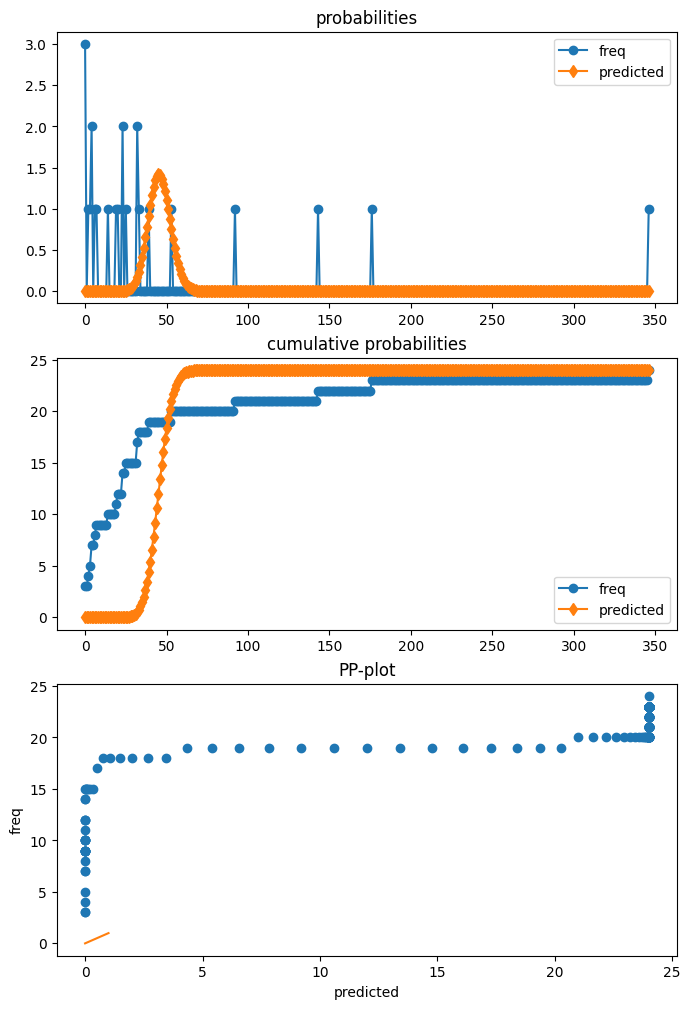

In [23]:
dia_p = res_p.get_diagnostic()
dia_p.plot_probs();

""" probplot is the same as a Q-Q plot, however probabilities are shown in the 
scale of the theoretical distribution (x-axis) and the y-axis contains unscaled quantiles of the sample data. """


#### Hurdle model Poisson-Poisson

In [24]:
mod_h = HurdleCountModel(y, x, dist='negbin')
res_h = mod_h.fit(disp=False)
print(res_h.summary())

                     HurdleCountModel Regression Results                      
Dep. Variable:                 ged_sb   No. Observations:                   24
Model:               HurdleCountModel   Df Residuals:                       21
Method:                           MLE   Df Model:                            0
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:               1.100e-11
Time:                        16:40:10   Log-Likelihood:                -110.93
converged:               [True, True]   LL-Null:                       -110.93
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
zm_const       0.7321      0.260      2.819      0.005       0.223       1.241
const          3.8393      0.324     11.843      0.000       3.204       4.475
alpha          2.0659      0.960      2.152      0.0

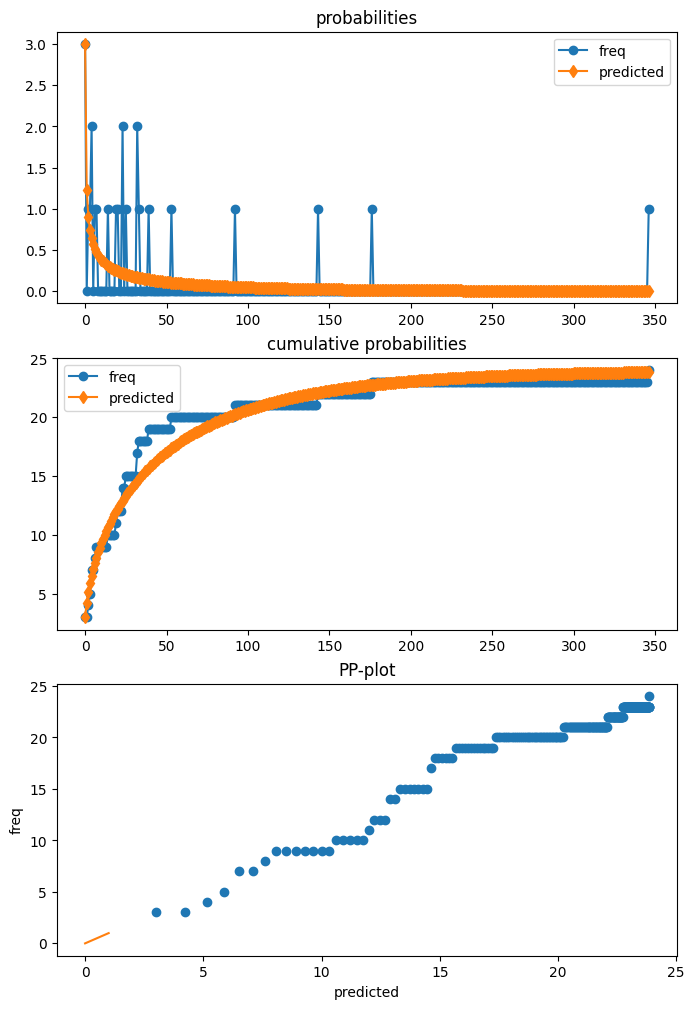

In [25]:
dia_h = res_h.get_diagnostic()
dia_h.plot_probs();

In [27]:
import numpy as np
import scipy.stats as stats

# Geschätzte Koeffizienten
intercept = 2.0

# Anzahl der Beobachtungen
num_observations = 1000

# Erzeuge eine negative Binomialverteilung
nbinom_dist = stats.nbinom(5, 0.5)  # Beispielwerte, passe sie an deine Daten an

# Generiere abhängige Variable basierend auf der Verteilung
dependent_variable = nbinom_dist.rvs(size=num_observations)

# Füge das Interzept hinzu
#dependent_variable += intercept

dependent_variable
# Jetzt hast du eine empirische Verteilung deiner Daten in der Variable dependent_variable


array([ 4,  6,  0,  6,  7,  4,  3,  4, 11, 10,  4,  8,  1,  9,  5,  4,  3,
        4,  4,  7, 10,  6,  8,  6,  7,  2,  5,  1,  2,  4,  6,  2,  5,  9,
        3, 10,  8,  1,  9,  1,  3,  6,  1,  8,  7,  5,  4,  5,  4,  4,  9,
       13,  2,  2,  1,  2,  7,  3,  1,  1,  5,  7,  5, 16,  3,  1,  5,  5,
        4, 12,  3,  7,  6,  1,  5, 13,  2,  4,  8,  6,  3,  8,  8,  2,  4,
       14,  3, 12,  5,  0,  5,  3,  2,  4,  9,  9,  5,  6,  6,  3,  6,  3,
        7, 13,  1,  2,  1,  6,  3,  3,  2,  4,  2,  4,  7,  4,  0,  1,  2,
        4,  6,  5,  4,  8,  7,  1,  5,  4,  2, 12,  3,  7,  5,  3,  1, 11,
        3,  7,  3,  5,  1,  2,  8,  6,  2, 10,  1,  1,  1,  0,  7, 13,  3,
        8,  3,  3, 10,  5,  6,  1,  4,  8,  6,  2,  8,  7, 10,  0,  8,  1,
        6,  6,  2,  5,  5,  6,  2, 11, 10,  4,  6, 13, 11,  5, 16,  6, 12,
        5,  3,  7,  3,  3,  7,  7,  3,  8,  7,  9,  4,  2,  3,  4,  1, 13,
        5,  8,  4, 10,  1,  3,  4, 15,  3,  6,  3,  5,  5, 10,  5,  4,  4,
        3,  3,  3,  2,  2

## Experimental code Hurdle function

In [ ]:
""" from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomial

data = country_feature_group_list[0].get_group(246)

# Hurdle-Modell erstellen
model = ZeroInflatedNegativeBinomial(data.loc[:,'ged_sb'], np.ones_like(data.loc[:,'ged_sb']), exog_infl=np.ones_like(data.loc[:,'ged_sb']))

# Modell anpassen
fit_model = model.fit()

# Vorhersagen aus dem Modell generieren
predictions = fit_model.predict()

# Empirische Verteilung aus den Vorhersagen ziehen
simulated_data = np.random.negative_binomial(predictions, fit_model.alpha, size=len(data))

# Datenplot
plt.scatter(data.loc[:,'month_id'], data.loc[:,'ged_sb'], label='Daten')
plt.scatter(data.loc[:,'month_id'], simulated_data, label='Simulierte Daten')
plt.xlabel('Month ID')
plt.ylabel('Fatalities')
plt.legend()
plt.show() """


In [ ]:
import scipy.special

def hurdle_negbin_pdf(n, y):

    # probability that the variable is zero
    pi = len(y[y>0])/len(y)

    # parameters of the negative binomial
    mean = np.mean(y[y>0])
    var = np.var(y[y>0])

    negBin = False

    if var != 0 and var > mean:
        n = (mean**2) / (var - mean) # equivalent to r
        p = mean / var
        negBin = True


    # n samples of the hurdle model
    #for i in range(n):


    


    """ cdf = []
    for yi in y:
        if yi == 0:
            cdf.append(1 - pi)
        else:
            numerator = pi * (1 - (1 + a*mu)**(-a-1))
            denominator = scipy.special.gamma(yi + a - 1) * scipy.special.gamma(a - 1)
            term1 = ((a-1) / (mu + a - 1))**(a-1)
            term2 = (mu / (mu + a - 1))**yi
            cdf.append(numerator / denominator * term1 * term2)
    return cdf """


In [18]:
y = np.array([0,0,0,0,0,2,3,4,5,6,7,8,8])

np.mean(y[y>0])



5.375